### Deepfake image classification using custom Convolutional Neural Network and Transfer Learning

#### Group Project by Ikhlaq Ahmad, Jared Seifert, and Tanvir Yousuf

# Data Pre-processing

In [1]:
# Dependencies
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import json

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Dropout, BatchNormalization)

from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications import ResNet50, EfficientNetV2B3
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Sk-learn Scikit
from sklearn.metrics import (confusion_matrix, auc, precision_recall_curve, f1_score, roc_curve,
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay,
                             classification_report, mean_squared_error, precision_score, recall_score, accuracy_score)
from sklearn.model_selection import train_test_split

##### GPU Check: (Nvidia GeForce RTX 3050 8GB DDR5 was utilized)

In [2]:
# Checks the availability of GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)

GPU is available and configured.


In [3]:
# Dataset Paths - Replace with your dataset path
dataset_path = "D:\ML_Seperated"  

#### Data Processing Pipeline
##### Data Preprocessing includes extracting data from subdirectories, parsing into corresponding labels, and spliting it into training and testing. 

##### All the Data was decoded, normalized and resized to 224x224x3 to better fit the base model. Finally, the data was augmented by filping and adjusting 

##### for brightness, contrast, hue, and saturation.

In [4]:
# List all object folders
object_folders = os.listdir(dataset_path)
print(object_folders)

['Fake', 'Real']


In [5]:
# Real and Fake Label Mapping
label_map = {'Real': 0, 'Fake': 1}

In [6]:
# Images and there corresponding labels' list
image_paths = []
labels = []

In [7]:
# Load images and labels into lists
for category, label in label_map.items():
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(file_path)
                labels.append(label)

In [8]:
# Display loaded data stats
print(f"Number of images loaded: {len(image_paths)}")
print(f"Class distribution: {Counter(labels)}")

Number of images loaded: 692824
Class distribution: Counter({1: 350768, 0: 342056})


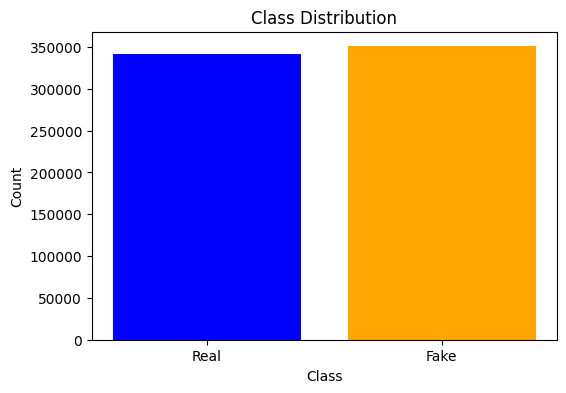

In [9]:
# Bar Chart showing image distributin by class
plt.figure(figsize=(6, 4))
plt.bar(label_map.keys(), Counter(labels).values(), color=['blue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

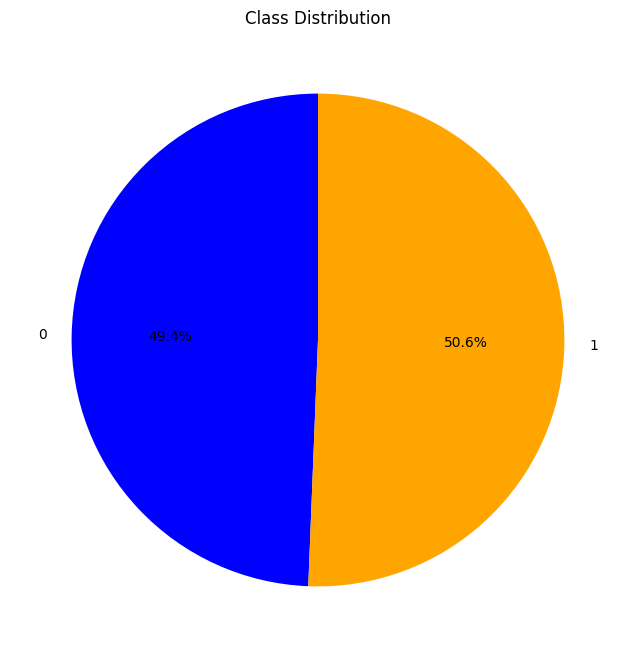

In [10]:
# Count occurrences of each class
class_counts = Counter(labels)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(list(class_counts.values()), labels=list(class_counts.keys()) , autopct='%1.1f%%', startangle=90, colors=["blue", "orange"])
plt.title('Class Distribution')
plt.show()

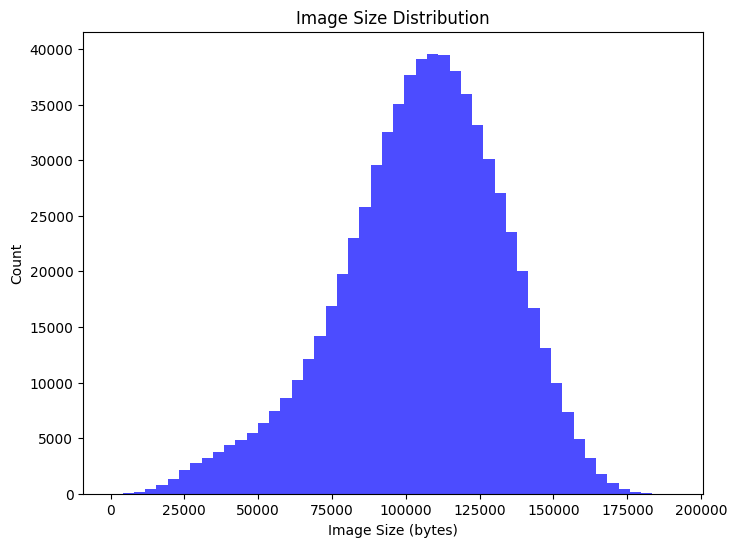

In [11]:
# Average Image Size Distribution (before)
image_sizes = [os.path.getsize(img) for img in image_paths]

plt.figure(figsize=(8, 6))
plt.hist(image_sizes, bins=50, color='blue', alpha=0.7)
plt.title("Image Size Distribution")
plt.xlabel("Image Size (bytes)")
plt.ylabel("Count")
plt.show()

In [12]:
# Limit to first 1000 images for efficiency - Pixel Intensity of the images
image_path_stats = image_paths[:1000]

In [13]:
# Variables for analysis
image_sizes = []
pixel_intensities = []
aspect_ratios = []

In [14]:
# Process images
for img_path in image_path_stats:
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    height, width = img_array.shape[:2]
    image_sizes.append((height, width))
    aspect_ratios.append(width / height)
    pixel_intensities.append(img_array.mean())

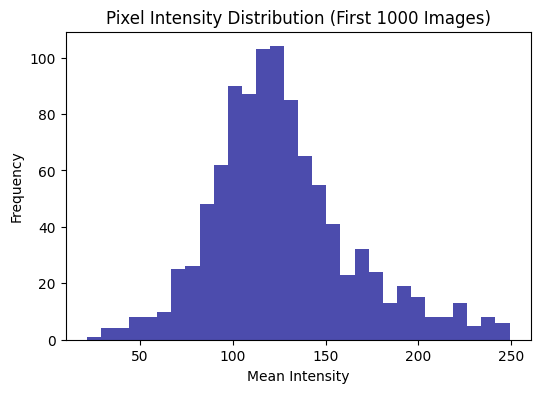

In [15]:
# Pixel Intensity Distribution (histogram)
plt.figure(figsize=(6, 4))
plt.hist(pixel_intensities, bins=30, color='darkblue', alpha=0.7)
plt.title("Pixel Intensity Distribution (First 1000 Images)")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.show()

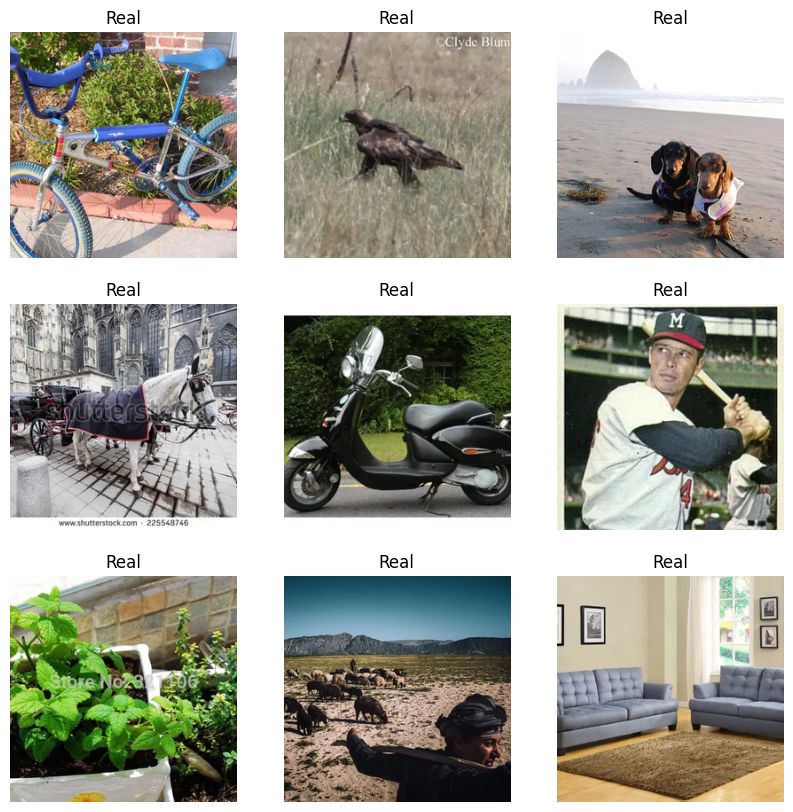

In [16]:
# Sample the first 9 images from the image_paths list
subset_image_paths = image_paths[:9]
subset_labels = labels[:9]

# Define class names
class_names = ['Real', 'Fake']

# Display images using matplotlib and Pillow (PIL)
plt.figure(figsize=(10, 10))
for i, (image_path, label) in enumerate(zip(subset_image_paths, subset_labels)):
    # Open the image using PIL
    image = Image.open(image_path)
    
    # Create a subplot for each image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)  # Display the image
    plt.title(class_names[label])  # Set the title to the label ('Real' or 'Fake')
    plt.axis("off")  # Hide axes for better image viewing

plt.show()

In [17]:
# Split data into training and validation sets using train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=labels)


In [18]:
# Train and Test split statistics
print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

Total images: 692824
Training images: 554259
Validation images: 138565


In [19]:
# load and preprocess images function
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    #image = image / 255.0  # Normalize pixel values to [0, 1]
    image = preprocess_input(image)
    return image, label

In [20]:
# Create TensorFlow training set using tensorflow slicing and data autotune using batch size of 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [21]:
# validation set
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [22]:
# Custom Data Augmentation for training data
def custom_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image, label

In [23]:
# Apply data augmentation only to the training dataset
train_dataset = train_dataset.map(custom_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
# Parameters Initialization
batch_size = 32
img_height = 224
img_width = 224
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.5
epsilon = 0.001

### ResNet50

##### For this project, we used ResNet50 with imagenet weights as our base model. 

##### It has 175 layers and we fine-tuned our data on the top 25 layers. 

### Model Layers

##### We chose the filter size as the power of 2^n, where n >= 4 and n <= 9.

##### Input size is 224x224x3. We used ReLU Activation and Max Pooling for each filter size with the learning rate of 0.001, then, we added Average 

##### Pooling and Sigmoid Activation using the Density of 1.

In [25]:
# Load ResNet50 as the base model (pretrained on ImageNet)
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [26]:
# Step 8: Freeze all layers except the last 50 layers for fine-tuning
base_model.trainable = False

In [27]:
# CNN model using filter size 16 and max pooling
model = Sequential()

In [28]:
# Add t as the base
model.add(base_model)

In [29]:
model.add(BatchNormalization(input_shape=input_shape))

In [30]:
filters = [16, 32, 64, 128, 256, 512]
for filter_size in filters:
    model.add(Conv2D(filters=filter_size, kernel_size=3, activation=activation, padding=padding))
    model.add(BatchNormalization(epsilon=epsilon))
    model.add(Dropout(droprate))

In [31]:
# Add average pooling using sigmoid activation
model.add(GlobalAveragePooling2D())

In [32]:
# Proceed with the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [33]:
# Trainble layers set to true
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [34]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [35]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 16)          294928    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 16)         64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4

In [37]:
# Reduces learning rate when the validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [38]:
# Callbacks for early stopping and model saving
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='ResNet50_checkpoint.h5', save_best_only=True)
]

### Model Fit

##### The model was trained with 10 epochs. 

In [42]:
# Train the model using 15 epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
17321/17321 [==============================] - 2374s 137ms/step - loss: 0.2183 - accuracy: 0.9065 - val_loss: 0.1232 - val_accuracy: 0.9472
Epoch 2/10
17321/17321 [==============================] - 2313s 134ms/step - loss: 0.1140 - accuracy: 0.9557 - val_loss: 0.0908 - val_accuracy: 0.9656
Epoch 3/10
17321/17321 [==============================] - 2303s 133ms/step - loss: 0.0784 - accuracy: 0.9704 - val_loss: 0.1028 - val_accuracy: 0.9596
Epoch 4/10
17321/17321 [==============================] - 2309s 133ms/step - loss: 0.0599 - accuracy: 0.9773 - val_loss: 0.1009 - val_accuracy: 0.9629
Epoch 5/10
17321/17321 [==============================] - 2308s 133ms/step - loss: 0.0494 - accuracy: 0.9817 - val_loss: 0.1119 - val_accuracy: 0.9562
Epoch 6/10
17321/17321 [==============================] - 2301s 133ms/step - loss: 0.0408 - accuracy: 0.9851 - val_loss: 0.0801 - val_accuracy: 0.9711
Epoch 7/10
17321/17321 [==============================] - 2301s 133ms/step - loss: 0.0358 - ac

In [43]:
# Save final model
model.save('D:\models\ResNet50_model.h5')
model.save('D:\models\ResNet50_model.keras')
print("Model training complete and saved!")

Model training complete and saved!


In [ ]:
 with open('ResNet50_history.json', 'w') as f:
 json.dump(history.history, f)

In [40]:
model = tf.keras.models.load_model("D:\models\ResNet50_model.keras")

In [41]:
if os.path.getsize("D:\models\ResNet50_history.json") == 0:
    print("The JSON file is empty.")
else:
    with open("D:\models\ResNet50_history.json", 'r') as f:
        loaded_history = json.load(f)


In [42]:
# Predict on validation set
val_predictions = model.predict(val_dataset)

4331/4331 [==============================] - 369s 84ms/step


In [43]:
# loss and accuracy using model evaluate
loss, accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

4331/4331 [==============================] - 369s 85ms/step - loss: 0.0770 - accuracy: 0.9734
Loss: 0.0770, Accuracy: 97.34%


In [44]:
# Predict on the validation dataset
val_predictions_classes = (val_predictions > 0.5).astype("int32")

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions_classes)

# Accuracy per class
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display accuracies
for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i} ({'Real' if i == 0 else 'Fake'}): {accuracy:.2f}")

# Print classification report for additional metrics
class_report = classification_report(val_labels, val_predictions_classes, target_names=['Real', 'Fake'])
print("\nClassification Report:\n", class_report)

Accuracy for class 0 (Real): 1.00
Accuracy for class 1 (Fake): 0.95

Classification Report:
               precision    recall  f1-score   support

        Real       0.95      1.00      0.97     68411
        Fake       1.00      0.95      0.97     70154

    accuracy                           0.97    138565
   macro avg       0.97      0.97      0.97    138565
weighted avg       0.97      0.97      0.97    138565



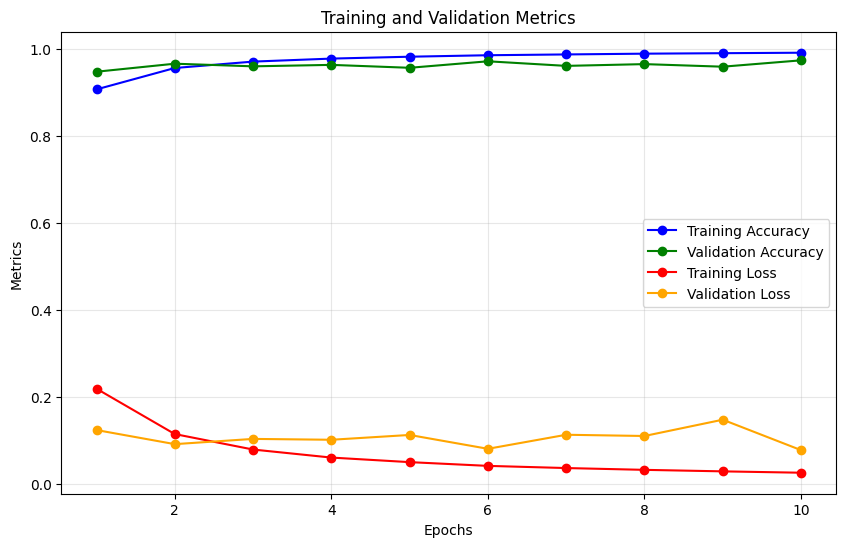

In [45]:
# Extract data from the JSON
history = loaded_history
epochs = range(1, len(history['accuracy']) + 1)
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Plot accuracy and loss on the same graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [46]:
# Predict on the validation dataset
# Convert probabilities to binary class labels
threshold = 0.5
val_predictions_binary = (val_predictions > threshold).astype(int)
print(val_predictions_binary)  # Output: [0 1 1 0]

#val_predictions_binary = np.round(val_predictions)  

# Extract the true labels
val_labels_list = np.concatenate([y for x, y in val_dataset], axis=0)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]


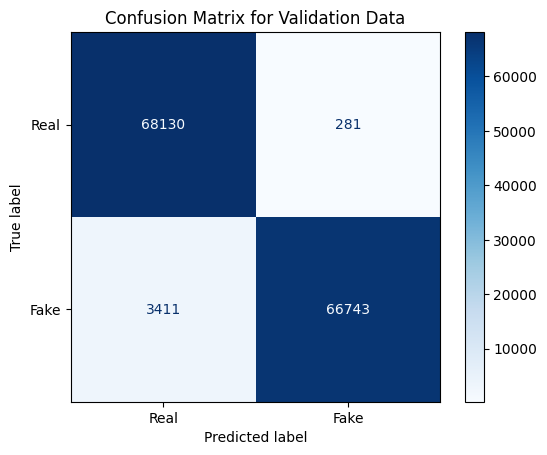

In [47]:
# Compute the confusion matrix
cm = confusion_matrix(val_labels_list, val_predictions_binary)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Validation Data')
plt.show()


In [48]:
# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Per-Class Accuracy:", per_class_accuracy)

Per-Class Accuracy: [0.99589247 0.9513784 ]


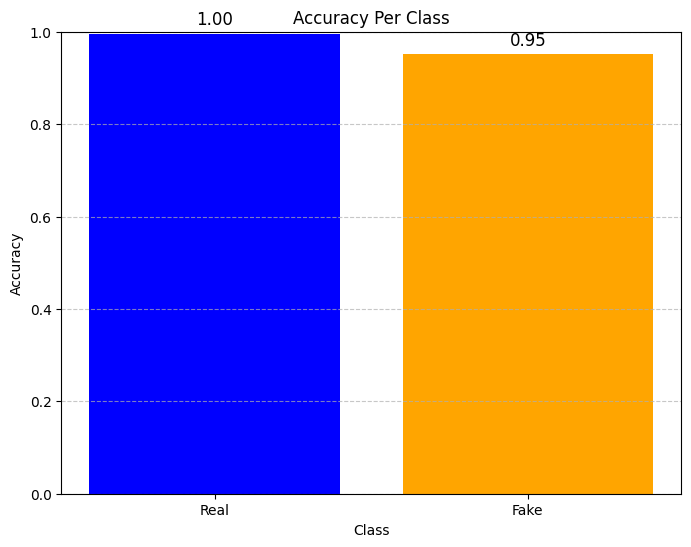

In [49]:
# Plot per-class accuracy
plt.figure(figsize=(8, 6))
plt.bar(class_names, per_class_accuracy, color=['blue', 'orange'])
plt.title('Accuracy Per Class')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, acc in enumerate(per_class_accuracy):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.show()

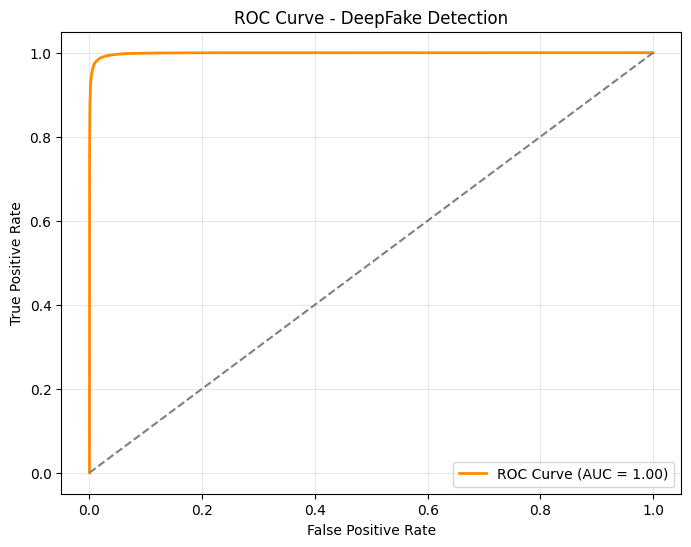

In [51]:
# Predict probabilities using the trained model
y_pred_probs = val_predictions.flatten()  # Predicted probabilities for the validation set

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and Thresholds
fpr, tpr, thresholds = roc_curve(val_labels, y_pred_probs)

# Compute AUC for the ROC Curve
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DeepFake Detection")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [61]:
# Predicting the labels for validation set
val_predictions = np.round(val_predictions).astype(int).flatten()  # Round sigmoid outputs to 0 or 1

# MSE (Mean Squared Error)
mse = mean_squared_error(val_labels, val_predictions)
# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Accuracy
accuracy = accuracy_score(val_labels, val_predictions)

# Precision
precision = precision_score(val_labels, val_predictions)

# Recall
recall = recall_score(val_labels, val_predictions)

# F1 Score
f1 = f1_score(val_labels, val_predictions)

# Print out all the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Mean Squared Error (MSE): 0.02664453505575001
Root Mean Squared Error (RMSE): 0.1632315381773694
Accuracy: 0.97335546494425
Precision: 0.9958074719503461
Recall: 0.9513783961000085
F1 Score: 0.9730860633629299


In [85]:
#!pip freeze > ml-model-requirements.txt